In [ ]:
#General comments about this code 
#Time steps 277 and 287 are discarded (are they still?)

In [54]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

In [55]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [56]:
#for more info on how this mask works, see https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py
all_basins = xmitgcm.utils.read_3d_llc_data('/home/jovyan/basins.data', nx=90,nz=1,nrecs=1,dtype='>f')
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [57]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [58]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [59]:
#Makes array of total volume transport above sigma=101 in the basin as a function of time
tr = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, 210, :].sum('l3_c') #at j_g = 210, up to sigma = 101
volume_over_time = tr.sum('i') 
#volume_over_time.load()
#volume_over_time

In [60]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:180] - volume_over_time 
#istar_over_time = (volume_over_i <0).argmax(dim='i') - yields an array of only zeroes
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) #largest

In [62]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
l_i = grid.interp(coords.XC, axis = 'Y')
long_interp = l_i[210, :]
istar1 = istar_over_time + 110
istar2 = long_interp[istar1]
#istar2.load()

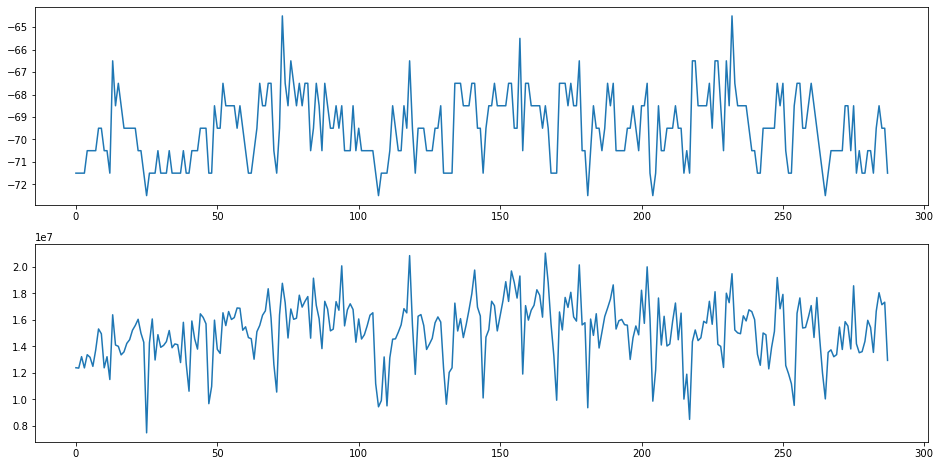

In [19]:
#x axis of time; top is longitude, bottom is net volume over time 
fig, axs = pltt.subplots(2, figsize=(16,8))
axs[0].plot(istar2)
axs[1].plot(volume_over_time)

In [18]:
#Ensure that the total volume at istar is the total volume on top of the band 
volume_at_istar = tr.where(tr.i < istar1).sum('i')
# volume_at_istar.load()

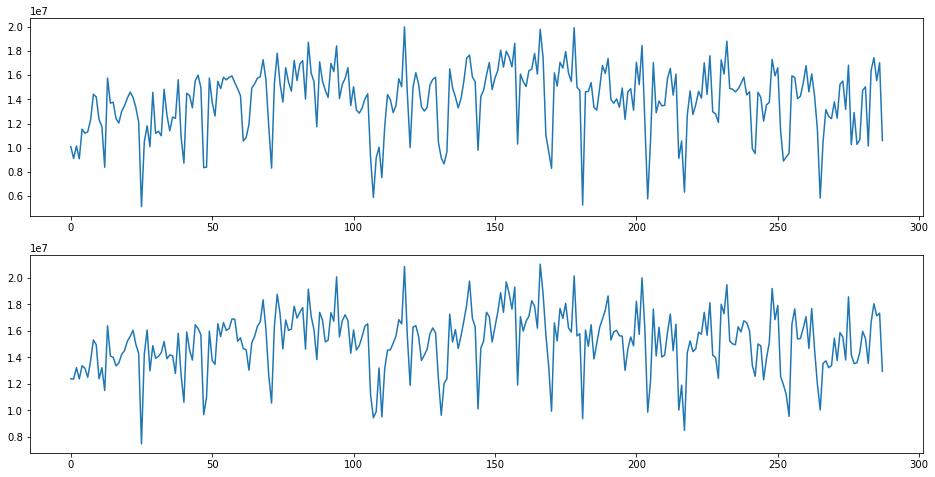

In [80]:
fig, axs = pltt.subplots(2, figsize=(16,8))
axs[0].plot(volume_at_istar)
axs[1].plot(volume_over_time)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


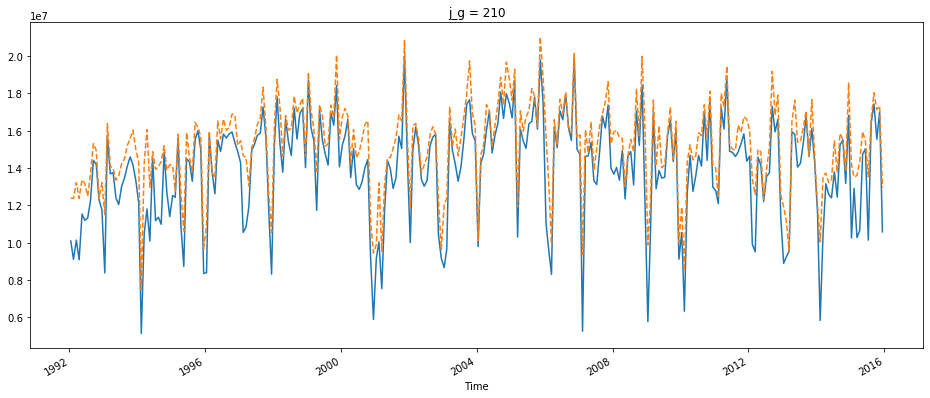

In [13]:
fig, ax = pltt.subplots(figsize=(16,6))
(volume_at_istar).plot(ax=ax)
(volume_over_time).plot(ax=ax, ls='--')

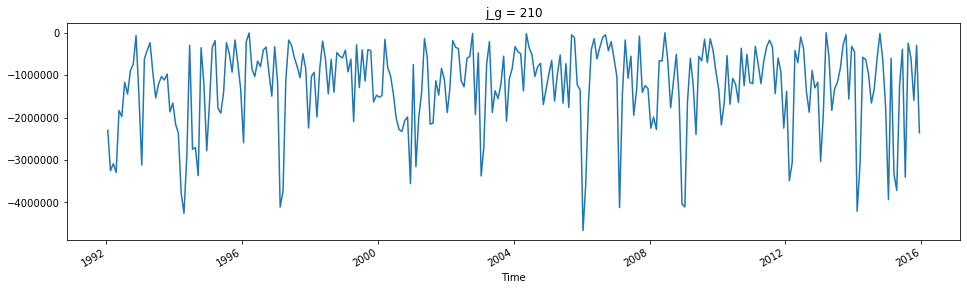

In [84]:
(volume_at_istar - volume_over_time).plot(figsize=(16,4))
#seems like volume at istar is smaller than volume over time at large?

In [105]:
#Investigate unusually large index at time=168
(volume_over_time - volume_at_istar).argmax(dim='time') 

<xarray.DataArray ()>
array(168)
Coordinates:
    j_g      int64 210

In [106]:
#istar at time 168 is 146
istar1[168]

<xarray.DataArray ()>
array(146)
Coordinates:
    j_g      int64 210
    time     datetime64[ns] 2006-01-15
    dt       float64 2.678e+06

In [110]:
volume_over_time[168] #volume of the top band at time 146

<xarray.DataArray ()>
array(15706952.96774827)
Coordinates:
    j_g      int64 210
    time     datetime64[ns] 2006-01-15
    dt       float64 2.678e+06

In [115]:
tr[168, :145].sum('i').values #has not attained the volume at 145

array(5529564.85520775)

In [116]:
tr[168, :146].sum('i').values #has not attained the volume at 146 

array(11044717.30102357)

In [117]:
tr[168, :147].sum('i').values #has surpassed the volume at 147 

array(15739344.52340349)

In [97]:
#test case to ensure that .where works as expected - consider times 0, 1 and 2 
#istar1[0] gets 146, as does istar[1] and 2
tr[0, :146].sum('i').values

array(10086950.05746691)

In [99]:
volume_at_istar[0]

<xarray.DataArray ()>
array(10086950.05746691)
Coordinates:
    j_g      int64 210
    time     datetime64[ns] 1992-01-15
    dt       float64 nan

In [100]:
tr[1, :146].sum('i').values

array(9107110.74972022)

In [101]:
volume_at_istar[1]

<xarray.DataArray ()>
array(9107110.74972022)
Coordinates:
    j_g      int64 210
    time     datetime64[ns] 1992-02-13
    dt       float64 2.506e+06

In [15]:
#Longitude plus 1 mapping 
istar3 = istar1 + 1
longitude_plus_one = long_interp[istar3]

In [39]:
longitude_plus_one - istar2

<xarray.DataArray (time: 288)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [ ]:
#Interpolation
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

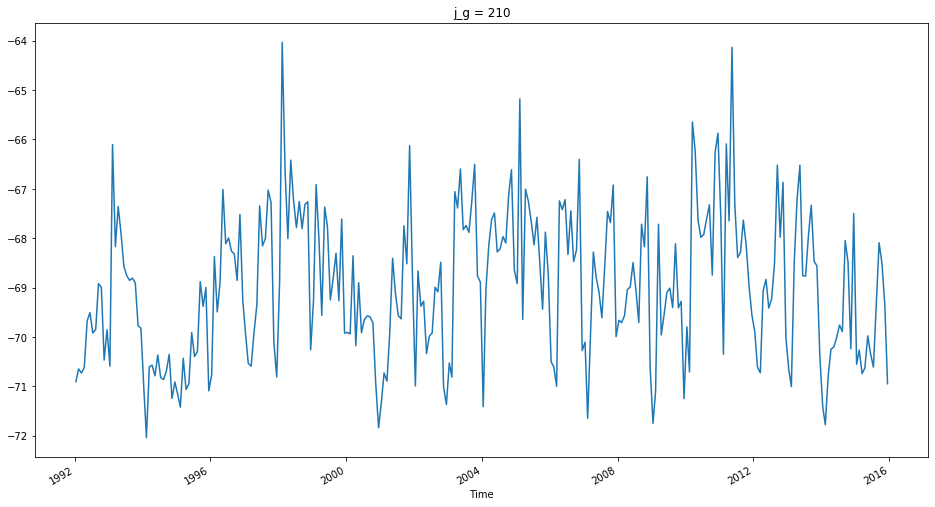

In [52]:
smooth_longitude =  ratio + istar2
smooth_longitude.plot(figsize=(16,8))

In [ ]:
volume_in_cell = ratio*difference 
interpolated_volume = volume_at_istar + volume_in_cell
fig, ax = pltt.subplots(figsize=(16,6))
(volume_in_cell).plot(ax=ax)
(volume_over_time).plot(ax=ax, ls='--')

In [ ]:
#Sigma is 101 and j_g is 210
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * ds.atl_maskS * rho0 * cp)[:, :, 210, :] #(time, l3_c, i)

In [ ]:
#top left and right
adv1 = a.where(a.i < istar1)
top_left = adv1[:, :101, :].sum(['i','l3_c'])

adv2 = a.where(a.i >= istar1)
top_right = adv2[:, :101, :].sum(['i','l3_c'])

bottom = a[:, 101:, :].sum(['l3_c', 'i'])

nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

In [ ]:
#Compute the next cell's advection - top left  
adv_nextcell = a.where(a.i < istar3)[:, :101, :].sum(['i','l3_c'])
adv_difference = adv_nextcell - top_left 
adv_topleft = ratio * adv_difference + top_left

In [ ]:
#top right 
top_right_adv = 